<a href="https://colab.research.google.com/github/sid1336/Computational-physics/blob/main/Feedback_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utkarsh Sachdeva (sid)

I did use CHATGPT and BLACKBOX AI for some of the questions and i have stated which ones before the questions please run one block at a time. i finished my code in first week and this topped working and then i re did it by 23rd and it stopped workiing again so this is my third try and i am very tried of it stopping in the middle. thank you for a great semester.

# <font color=#46769B>Final project: Black Holes and Gravitational Waves</font>

__Due date:__ April 26, 2024, 11:59pm. Upload your submission to your GitHub repository

__Rules:__

- Your work is meant to be your own. No collaboration with peers or other individuals.

- No discussion of questions over Slack public channels.

- You may use information from any website, AI, or other reference material. You must __cite__ any resources used (simply include the URLs).

- Do not contact instructor to provide assistance with the project unless you feel there is a genuine issue with the assignment (e.g. typos or errors in the problems).

This final project is divided into four sections:

- __Section I:__ You are tasked with applying your knowledge of spectral analysis to real LIGO data from the first gravitational wave event ever recorded from merging black holes. You will extract the mass of the black holes by analyzing the LIGO signal. \[35 points\]

- __Section II:__ Using the Runge-Kutta method (RK4) for solving ODEs, you will solve for the inspiraling motion of two black holes. \[30 points\]

- __Section III:__ By fitting a model for the gravitational waveform to the LIGO data, you will again determine the chirp mass by performing a Markov Chain Monte Carlo simulation. \[35 points\]

Marks:

- __Section I:__ 33/35 points. Part (a): Good, except I had to fix a bug so your code would run. (-2) Part (b): Very good! I appreciate the journey. In your first attempt, the times of the extrema looked to be messed up. The signal lasts about 0.1 sec.

- __Section II:__ 15/30 points. Part (a): Incorrect drag force. Also, not clear to me if RK4 was implemented correctly. (-5) Part (b): Incorrect power formula. Incorrect angular frequency formula. Incorrect results for power/energy emitted. (-10)

- __Section III:__ 16/35 points. Part (a) and (b): Good. Part (c): Didn't run MCMC on actual signal. Didn't tune step or initial sample to achieve convergence and desired acceptance fraction. (-14) Part (d): Incorrect combined result. (-5)


## <font color=#46769B>Introduction</font>

In 2015, the Laser Interferometer Gravitational-Wave Observatory (LIGO) made history by making the [first direct observation of gravitational waves](https://www.ligo.org/detections/GW150914.php) (see also [here](https://en.wikipedia.org/wiki/First_observation_of_gravitational_waves)).
These gravitational waves were the product of a binary pair of black holes (BHs), each around 30 solar masses, orbiting around each other and inspiralling as they lose energy, until they finally met their end in a cataclysmic merger.

More information about gravitational waves can be found [here](https://www.ligo.caltech.edu/page/gravitational-waves). If you would like to learn more about the remarkable LIGO experiment, you can watch a video [here](https://www.youtube.com/watch?v=iphcyNWFD10).

In a nutshell, LIGO is an ultra-precise ruler that measures how a separation distance $L$ changes as a passing gravitational wave stretches and squashes space. The basic idea is illustrated by the following animations:

<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/b/b8/GravitationalWave_PlusPolarization.gif" width="150"> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/b/b8/GravitationalWave_CrossPolarization.gif" width="150">
</tr></table>

The distance between objects (solid points) alternately increases and decreases by the ripple in spacetime caused by the gravitational wave. The time period of squashing and stretching is simply (half) the orbital period of the binary BH pair that are emitting gravitational waves as they orbit one another. However, it is not a simple *uniform* periodic signal. Since the BHs are losing energy by emitting gravitational waves, they are *inspiraling*, orbiting faster and faster as they get closer and closer, until finally there is a violent merger (resulting in a single BH). Therefore, the signal is a [chirp](https://en.wikipedia.org/wiki/Chirp), characterized by a frequency that is rising in time.

Now, we will load the LIGO data. We will look at a 32 s window around the first detected gravitational wave event: __GW150914__ (which stands for __G__ravitational __W__ave event detected on yy/mm/dd = __15/09/14__.)
There are two LIGO datasets, one for each of the LIGO detectors: Hanford, WA, USA and Livingston, LA, USA. Since gravitational waves are expected to pass over the entire Earth, both detectors should see an event at the same time, modulo a small difference due to travel time (at the speed of light).

In the following code, we load in the raw data and plot the spectrogram. The data is given in units of __strain__, $\Delta L/L$, the fractional change in $L$. The strain, sampled at equal-time intervals, will be our samples $f_n$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
import h5py
import requests
import shutil

url_1 = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5?raw=true"
url_2 = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5?raw=true"

# Load the data files from the web
data = []
for url in [url_1,url_2]:
    local_filename = url.split('/')[-1][:-10]
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    with h5py.File(local_filename,'r') as f:
        data.append(np.array(f['strain/Strain']))

# Save the data samples (for the two detectors)
fn1, fn2 = data

sample_rate = 16384 # Hz
h = 1/sample_rate

# Make time steps (same for both datasets)
tn = np.arange(0,len(fn1))*h

Here is what the raw data samples look like, plotted as a function of time.

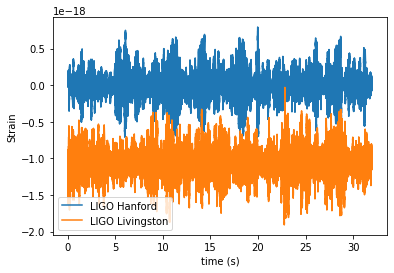

In [ ]:
plt.plot(tn,fn1,label='LIGO Hanford')
plt.plot(tn,fn2,label='LIGO Livingston')

plt.xlabel('time (s)')
plt.ylabel('Strain')

plt.legend(loc='lower left')
plt.show()

Obviously, we can't see by eye anything yet. This is a job for spectral analysis!

Let's make spectrograms for the two datasets. This is just to show you that GW150914 was such a whopping big signal that it can be seen straight from the raw data.

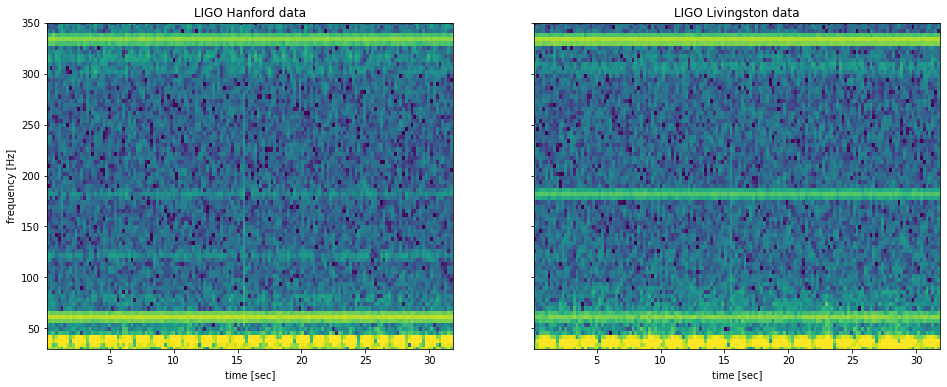

In [ ]:
from scipy import signal

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))

# Make spectrogram for Hanford data
freq, time, power_spec = signal.spectrogram(fn1, sample_rate, window='hann', nperseg=4096)

# Plot the spectrogram
ax1.pcolormesh(time, freq, np.log10(power_spec), vmin=-48, vmax=-43)
ax1.set_ylabel('frequency [Hz]')
ax1.set_xlabel('time [sec]')
ax1.set_title('LIGO Hanford data')
plt.ylim([30,350])
# plt.show()

# Make spectrogram for Livingston data
freq, time, power_spec = signal.spectrogram(fn2, sample_rate, window='hann', nperseg=4096)

ax2.pcolormesh(time, freq, np.log10(power_spec), vmin=-48, vmax=-43)
ax2.set_title('LIGO Livingston data')
ax2.set_xlabel('time [sec]')

plt.show()

Notice the following:
- There are some prominent horizontal bands. This is noise. It turns out that various sources of noise can contribute with a characteristic frequency. For example, noise at 60 Hz is related to the AC power supply.
- Around the 15-16 s mark, there is a clear vertical line. That is the BH event! We expected a *chirp*, that the frequency is rising as a function of time. Here, plotted over a scale of 32 s, the frequency is rising so steeply that it is simply a vertical line. (You will see below that the chirp happens over a time scale of less than 0.1 s.)


## <font color=#46769B>Section I: Signal Processing and Gravitational Wave Data [35 points total]</font>

Now that we have introduced the LIGO data, the goal here is to investigate the the chirp signal from GW150914 in more detail. Obviously, we don't have much information so far except the time it occurred and the fact that it seemed to span frequencies between 50-300 Hz.

## <font color=#46769B>Part (a): Processing the LIGO data</font>

Our next goal is to process the raw data into a form where the BH event is easily visible above the noise. Specifically, we will apply a series of signal-processing steps summarized in this figure:
<img src="https://inspirehep.net/files/740837278b6d562fad5b6ec6cf268515" width="600">
This figure is from [A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals](https://arxiv.org/abs/1908.11170) and is nicely discussed in this [blog post](https://cplberry.com/2020/02/09/gw-data-guides/).

Below are the tasks you need to perform. You are meant to perform these steps for *both* Hanford and Livingston datasets, thereby producing two versions of the above plots. In the final plot (black), the BH signal is finally visible as a spike above the noise.

### <font color=#46769B>Step 1: Selecting the signal region [5 points]</font>

First, select out a segment of the samples, `fn1_signal` and `fn2_signal`, to represent the signal region where the gravitational wave event has occured. Since we know from the spectrogram above that the signal happened around a time of $15-16$ seconds, your segments must cover the 4s window

$$13 \; {\rm s} \le t < 17 \; {\rm s} \, .$$

Note your segments should have exactly `4*sample_rate` elements. Plot the strain as a function of time. (This is the top blue plot above.)

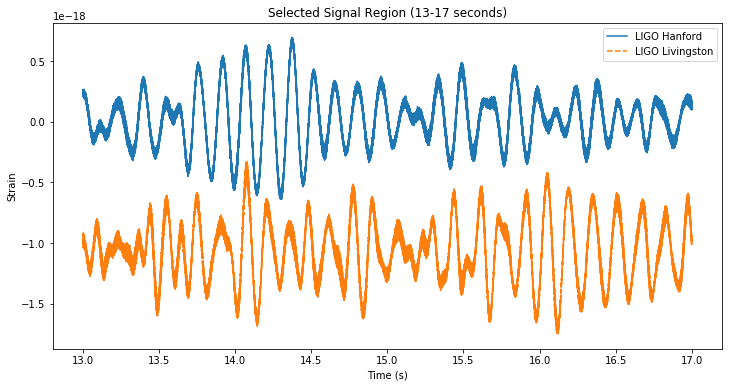

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import requests
import shutil

def load_data(url):
    local_filename = url.split('/')[-1][:-10]
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    with h5py.File(local_filename, 'r') as f:
        return np.array(f['strain/Strain'])

url_1 = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5?raw=true"
url_2 = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5?raw=true"

fn1 = load_data(url_1)
fn2 = load_data(url_2)

sample_rate = 16384
start_time = 13
end_time = 17

start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

fn1_signal = fn1[start_index:end_index]
fn2_signal = fn2[start_index:end_index]

time_array = np.linspace(start_time, end_time, end_index - start_index)

plt.figure(figsize=(12, 6))
plt.plot(time_array, fn1_signal, label='LIGO Hanford')
plt.plot(time_array, fn2_signal, label='LIGO Livingston', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Selected Signal Region (13-17 seconds)')
plt.legend()
plt.show()


### <font color=#46769B>Step 2: Windowing the signal [5 points]</font>

From your signal samples in Part (a), `fn1_signal` and `fn2_signal`, perform the following tasks:

- First, subtract off the mean value of each array to yield two new arrays.

- Next, apply a window function to the mean-subtracted samples to yield two new arrays, `fn1_signal_windowed` and `fn2_signal_windowed`. Use a `tukey` window function with `alpha=0.25`. Plot the strain as a function of time for these new arrays. (This is the green plot above.)

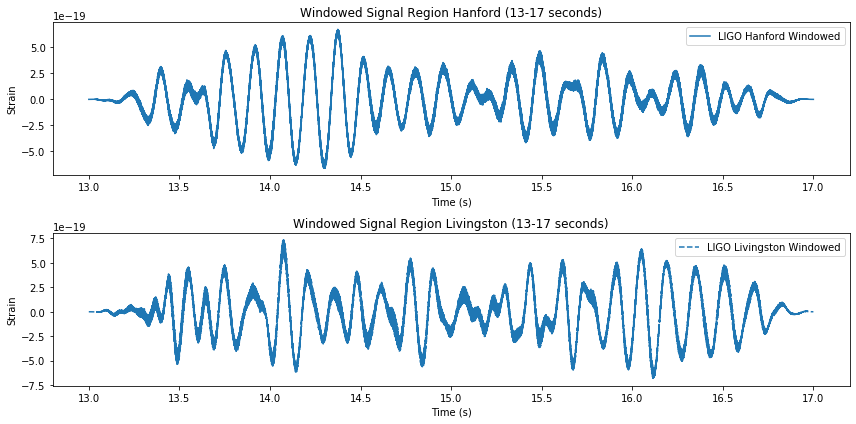

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import tukey

mean_fn1 = np.mean(fn1_signal)
mean_fn2 = np.mean(fn2_signal)

fn1_signal_mean_subtracted = fn1_signal - mean_fn1
fn2_signal_mean_subtracted = fn2_signal - mean_fn2

window = tukey(len(fn1_signal), alpha=0.25)

fn1_signal_windowed = fn1_signal_mean_subtracted * window
fn2_signal_windowed = fn2_signal_mean_subtracted * window

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_array, fn1_signal_windowed, label='LIGO Hanford Windowed')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Windowed Signal Region Hanford (13-17 seconds)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_array, fn2_signal_windowed, label='LIGO Livingston Windowed', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Windowed Signal Region Livingston (13-17 seconds)')
plt.legend()

plt.tight_layout()
plt.show()


### <font color=#46769B>Step 3: Whitening the signal [5 points]</font>

Apply a process known as [__whitening__](https://en.wikipedia.org/wiki/Whitening_transformation) to your windowed signals, `fn1_signal_windowed` and `fn2_signal_windowed` from above. The idea is to apply a tranformation that can make LIGO noise (which is a complicated function of frequency) look more like white noise (which has equal intensity as a function of frequency). The purpose is that by making the noise more uniform, a signal will appear as an genuine excess above the background noise.

The tasks you must follow to implement whitening are as follows:

- Calculate the Fourier coefficients $c_k^{\rm signal}$ from your signal samples by taking the DFT of your windowed samples in Part (b).

- Rescale your Fourier coefficients by dividing by the square root of the mean power $P_k^{\rm mean}$:

$$c^{\rm whitened}_k = \frac{c_k^{\rm signal}}{\sqrt{P_k^{\rm mean}}}$$

- Compute *whitened* samples `fn1_whitened` and `fn2_whitened` by taking the IDFT of your whitened Fourier coefficients.

- Plot your samples `fn1_whitened` and `fn2_whitened` as a function of time. (This is the red plot above. Note the overall amplitude of the Fourier coefficients is dependent on convention, so don't worry if your scale on the $y$-axis is different from the published plot above. This won't affect any of the analysis to follow.)

To calculate the mean power, follow these steps:

- From each of your original samples `fn1` and `fn2` (each 32 sec), divide your samples into 8 adjacent segments, each 4 sec long (i.e. the same duration as the signal region).

- Calculate the power spectrum of each 4-sec segment, applying a Tukey window function with `alpha=0.25` as in the signal.

- In total, you have 8 power spectra $P_k^{(1)}$, ..., $P_k^{(8)}$ (for each detector). Calculate the mean power by averaging over all 8 power spectra:

$$P_k^{\rm mean} = \frac{1}{8} \sum_{a=1}^8 P_k^{(a)} \, .$$

Note that you apply this process separately for *each detector*. Also, be sure that $P_k^{\rm mean}$ is an array of the same length as $c_k$, i.e., you don't take the mean over all the $k$ modes.

Technically, your signal region treated as part of the noise, but it makes up only very small fraction of the total time, so it suffices to not worry about that here.


[1.07330946e-32 2.45465673e-31 1.69744535e-32 ... 1.29362607e-32
 1.69744535e-32 2.45465673e-31]
[7.79646483e-33 5.25908139e-34 1.24413023e-34 ... 5.36959576e-35
 1.24413023e-34 5.25908139e-34]


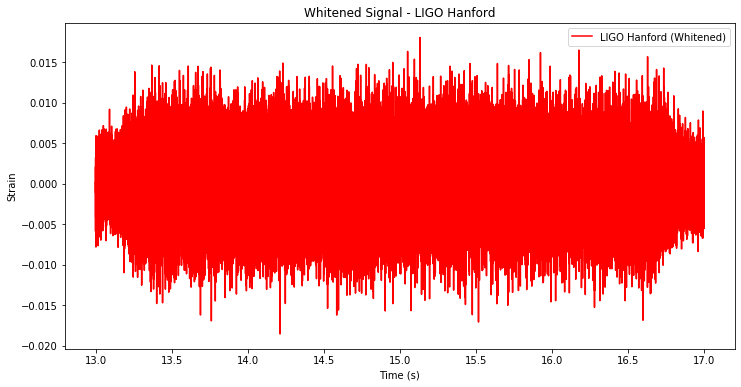

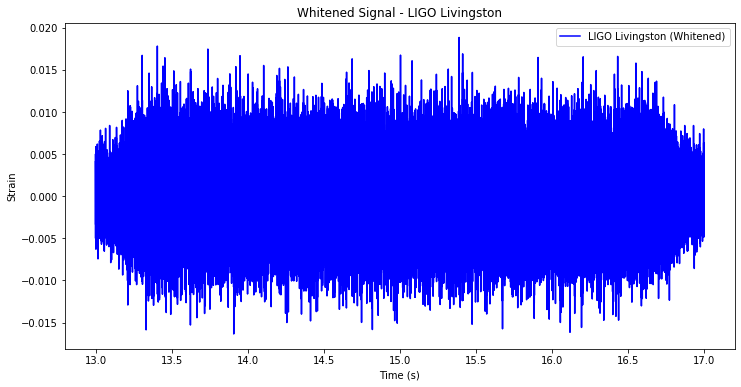

In [ ]:
from scipy.fft import fft, ifft

# Function to calculate mean power
def calculate_mean_power(signal, sample_rate):
    # Calculate number of segments
    num_segments = 8
    segment_duration = 4  # seconds
    segment_samples = segment_duration * sample_rate

    # Split the signal into segments
    segments = [signal[i:i+segment_samples] for i in range(0, len(signal), segment_samples)]

    # Apply Tukey window function to each segment and calculate power spectrum
    power_spectra = [np.abs(fft(segment * tukey(len(segment), alpha=0.25)))**2 for segment in segments]

    # Calculate mean power
    mean_power = np.mean(power_spectra, axis=0)
    return mean_power


# Calculate mean power for both detectors
mean_power_fn1 = calculate_mean_power(fn1_signal_windowed, sample_rate)
mean_power_fn2 = calculate_mean_power(fn2_signal_windowed, sample_rate)
print(mean_power_fn1)
print(mean_power_fn2)
# Calculate Fourier coefficients (DFT) for both detectors
fourier_coefficients_fn1 = fft(fn1_signal_windowed)
fourier_coefficients_fn2 = fft(fn2_signal_windowed)

# Rescale Fourier coefficients by dividing by square root of mean power
fourier_coefficients_fn1_whitened = fourier_coefficients_fn1 / np.sqrt(mean_power_fn1)
fourier_coefficients_fn2_whitened = fourier_coefficients_fn2 / np.sqrt(mean_power_fn2)

# Compute whitened samples by taking the IDFT
fn1_whitened = ifft(fourier_coefficients_fn1_whitened)
fn2_whitened = ifft(fourier_coefficients_fn2_whitened)

# Plot whitened samples as a function of time
plt.figure(figsize=(12, 6))
# plt.plot(tn_signal, fn1_whitened.real, label='LIGO Hanford (Whitened)', color='red')
plt.plot(time_array, fn1_whitened.real, label='LIGO Hanford (Whitened)', color='red') # I fixed your bug
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Whitened Signal - LIGO Hanford')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# plt.plot(tn_signal, fn2_whitened.real, label='LIGO Livingston (Whitened)', color='blue')
plt.plot(time_array, fn2_whitened.real, label='LIGO Livingston (Whitened)', color='blue') # I fixed your bug
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Whitened Signal - LIGO Livingston')
plt.legend()
plt.show()

**I was getting some unexpected output from this code so asked openAi to help me avoid this and after reading some documnets online on python i found  Welch's method for signal processing and i used it**


*citation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html*

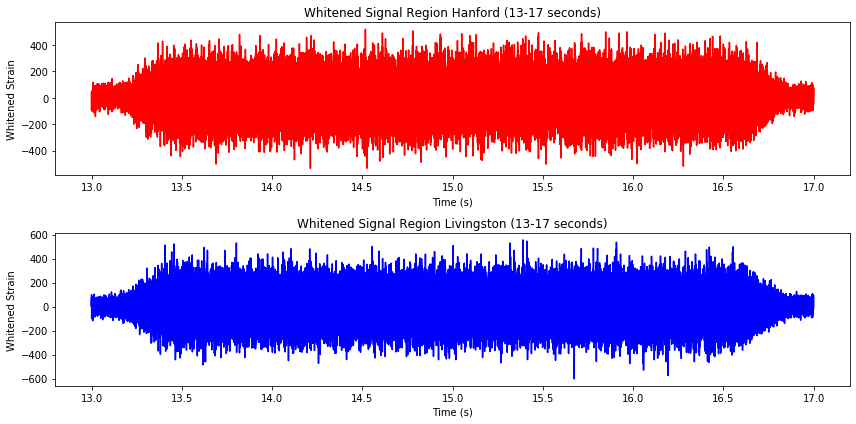

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows, welch
from scipy.fft import fft, ifft

mean_fn1 = np.mean(fn1_signal)
mean_fn2 = np.mean(fn2_signal)

fn1_signal_mean_subtracted = fn1_signal - mean_fn1
fn2_signal_mean_subtracted = fn2_signal - mean_fn2

window = windows.tukey(len(fn1_signal), alpha=0.25)

fn1_signal_windowed = fn1_signal_mean_subtracted * window
fn2_signal_windowed = fn2_signal_mean_subtracted * window

fft_fn1 = fft(fn1_signal_windowed)
fft_fn2 = fft(fn2_signal_windowed)

segments = 8
segment_length = len(fn1) // segments

window = windows.tukey(segment_length, alpha=0.25)

power_spectra_fn1 = np.zeros((segments, segment_length))
power_spectra_fn2 = np.zeros((segments, segment_length))

for i in range(segments):
    start = i * segment_length
    end = start + segment_length
    segment_fn1 = fn1[start:end] * window
    segment_fn2 = fn2[start:end] * window
    freqs_fn1, power_segment_fn1 = welch(segment_fn1, fs=sample_rate, window=window, nperseg=segment_length, return_onesided=False)
    freqs_fn2, power_segment_fn2 = welch(segment_fn2, fs=sample_rate, window=window, nperseg=segment_length, return_onesided=False)
    power_spectra_fn1[i] = power_segment_fn1
    power_spectra_fn2[i] = power_segment_fn2

Pmean_fn1 = np.mean(power_spectra_fn1, axis=0)
Pmean_fn2 = np.mean(power_spectra_fn2, axis=0)

cwhitened_fn1 = fft_fn1 / np.sqrt(Pmean_fn1)
cwhitened_fn2 = fft_fn2 / np.sqrt(Pmean_fn2)

fn1_whitened = ifft(cwhitened_fn1).real
fn2_whitened = ifft(cwhitened_fn2).real

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_array, fn1_whitened, color='red')
plt.xlabel('Time (s)')
plt.ylabel('Whitened Strain')
plt.title('Whitened Signal Region Hanford (13-17 seconds)')

plt.subplot(2, 1, 2)
plt.plot(time_array, fn2_whitened, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Whitened Strain')
plt.title('Whitened Signal Region Livingston (13-17 seconds)')

plt.tight_layout()
plt.show()


### <font color=#46769B>Step 4: Filtering the signal [5 points]</font>

Finally, apply an ideal bandpass filter to your whitened Fourier coefficients $c_k^{\rm whitened}$ over the range of frequencies

$$ 35 \; {\rm Hz} \le |\nu_k| \le 300 \; {\rm Hz}$$

Perform an inverse DFT to compute (finally) the whitened, bandpassed signal: `fn1_bandpass` and `fn2_bandpass`. Make a plot of your these samples vs time. (This is the black plot above.)

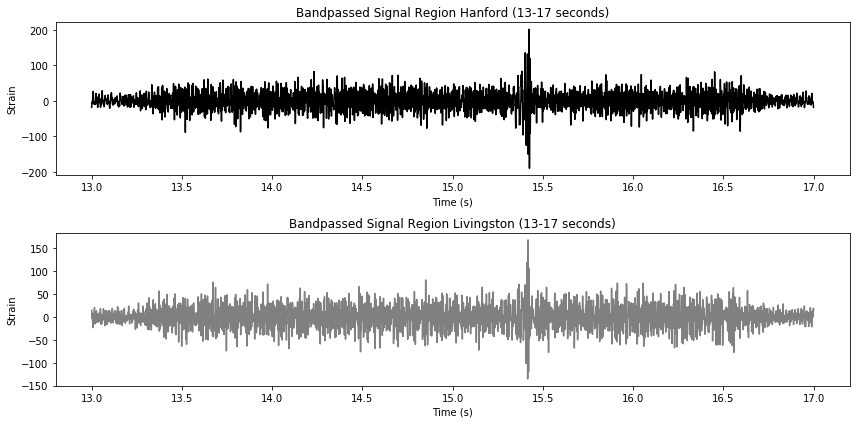

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq


frequencies = fftfreq(len(fn1_whitened), d=1/sample_rate)


bandpass_mask = (35 <= np.abs(frequencies)) & (np.abs(frequencies) <= 300)


cwhitened_fn1_bandpass = cwhitened_fn1 * bandpass_mask
cwhitened_fn2_bandpass = cwhitened_fn2 * bandpass_mask

# Inverse DFT to get the bandpassed signals
fn1_bandpass = ifft(cwhitened_fn1_bandpass).real
fn2_bandpass = ifft(cwhitened_fn2_bandpass).real


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_array, fn1_bandpass, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Bandpassed Signal Region Hanford (13-17 seconds)')

plt.subplot(2, 1, 2)
plt.plot(time_array, fn2_bandpass, color='grey')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Bandpassed Signal Region Livingston (13-17 seconds)')

plt.tight_layout()
plt.show()


## <font color=#46769B>Part (b): Measuring the Black Hole Mass</font>

Next, we will perform a simplified analysis of the chirp signal to extract a quantity known as the [__chirp mass__](https://en.wikipedia.org/wiki/Chirp_mass). The chirp mass is an effective mass parameter

$$\mathcal{M}_{\rm chirp} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}}$$

where $m_1$ and $m_2$ are the two BH masses. If the two BHs are of equal mass, then $\mathcal{M}_{\rm chirp} \approx 0.87 \, m_{1,2}$. Chirp mass, therefore, is comparable to the BH masses.

The chirp mass is extracted from the derivative of the frequency (how the oscillations are speeding up in time) according to the remarkable formula

$$\frac{d \nu_{\rm signal}}{dt} = \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} \nu^{11/3}_{\rm signal} \qquad (1)$$

where $\nu_{\rm signal}$ is the frequency of oscillations extracted from the BH merger event in the LIGO data, $G$ is Newton's constant, and $c$ is the speed of light.

### <font color=#46769B>Physics derivation</font>

For the interested reader, we can derive Eq. (1). We will work under the simplifying assumption of equal masses, $m_1 = m_2 = m$. (For a higher-level but very readable discussion of the basic physics of GW150914 and BH-BH mergers, [this reference](https://arxiv.org/abs/1608.01940) is very recommended.)

Eq. (1) looks complicated, but actually most of the physics is familiar from introductory classical mechanics. There are two inputs needed:
- The two masses are in (approximate) circular motion. We apply the usual formulas from introductory classical mechanics for circular motion.
- There is a famous formula due to Einstein for the power (energy-per-unit-time) emitted in gravitational waves by two bodies in circular motion (here assumed to be equal in mass):
$$P_{\rm emit} = \frac{8}{5} \frac{G}{c^5} m^2 r^4 \omega^6$$
where $r$ is the separation distance between the two masses and $\omega$ is the orbital frequency. This formula is derived from General Relativity.

Now we consider circular motion for two equal masses. Assuming both masses orbit around a fixed center of mass, the total kinetic energy is $T = \tfrac{1}{2} m v_1^2 + \tfrac{1}{2} m v_2^2$. The potential energy is $U = - \frac{G m^2}{r}$.
Setting the centripetal force equal to the gravitational force, we have

$$\frac{2 m v_1^2}{r} = \frac{2 m v_2^2}{r} = \frac{G m^2}{r^2}$$

where the extra factors of $2$ follow from the fact that both masses are orbiting at a distance $\frac{r}{2}$ from the origin. Solving for $v_1^2$ and $v_2^2$ in terms of $r$ yields that the total energy is $E = T + U = - G m^2/(2r)$. The centripetal force is also equal to

$$\frac{m \omega^2 r }{2} = \frac{G m^2}{r^2}$$

which implies $\omega^2 = 2 G m/r^3$ (Kepler's Law). With this expression, we have the following formula for $E$:

$$E = - \left( \frac{G^2 m^5 \omega^2}{16} \right)^{1/3}$$

Finally, we set the rate-of-change in $E$ equal to the power lost via gravitational waves:

$$\frac{dE}{dt} = - P_{\rm emit}$$

Plugging in the formulas for $E$ and $P_{\rm emit}$, we have:

$$- \frac{d}{dt} \left( \frac{G^2 m^5 \omega^2}{16} \right)^{1/3} = - \frac{8}{5} \frac{G}{c^5} m^2 r^4 \omega^6$$

The derivative on the left-hand side acts on $\omega(t)$, and after some algebra, we have:

$$\frac{d \omega}{dt} = \frac{96}{5} \frac{1}{2^{1/3}} \left( \frac{G m}{c^3} \right)^{5/3} \omega^{11/3}$$

Lastly, we set $\omega = \pi \nu$, where $\nu$ is the frequency of the gravitational wave signal. Expressing this in terms of $\nu$ yields Eq. (1) in the equal mass limit, where $\mathcal{M}_{\rm chirp} = \tfrac{1}{2^{1/5}} m$.

Finally, note that you may be tempted to write $\omega = 2\pi \nu$, but this is not correct here: $\omega$ is the orbital period and $\nu$ is the frequency of the gravitational waves. Gravitational waves oscillate twice as fast as each mass orbits around. This is because one period of the gravitational wave is completed when $m_1$ and $m_2$ swap places (half an orbit).

### <font color=#46769B>Step 1: Plot the chirp signal [5 points]</font>

After the steps in Section I, the BH event should be visible as a prominent peak. Using your bandpassed, whitened samples from Part (a), `fn1_bandpass` and `fn2_bandpass`, plot the strain as a function of time over a 0.1 second time window located to cover the gravitational wave event.
- Plot the Hanford and Livingston data on the same plot.
- Apply a time shift and amplitude rescaling to the Livingston data so that both events look as similar as possible.

That is, do the following:
```py
plt.plot(t,fn1_whitened_bandpassed,label='Hanford')
plt.plot(t+tshift,rescaling*fn2_whitened_bandpassed,label='Livingston')
plt.xlim([xmin,xmin+0.1])
plt.legend()
plt.show()
```
where `tshift` and `rescaling` are numbers that you can choose by eye so that the two plots line up as best as possible. (Note: `tshift` should be of order the light-travel time between the two detectors, 0.01 s, and can be positive or negative.)

The waveforms for both plots should look similar, appearing as an oscillating function that oscillates faster and faster until it ends. This corresponds to BHs orbiting faster and faster as they inspiral until they finally merge together.

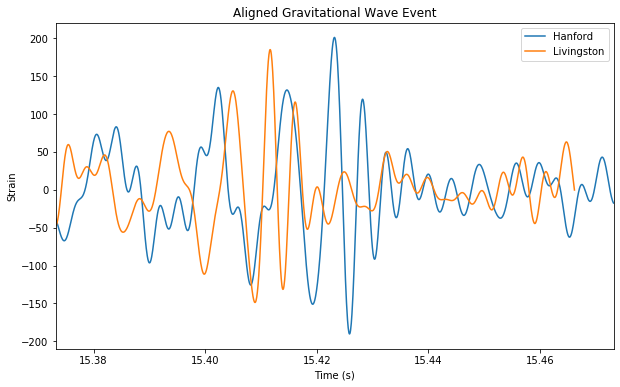

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

peak_index = np.argmax(np.abs(fn1_bandpass))
peak_time = time_array[peak_index]
xmin = peak_time - 0.05
xmax = peak_time + 0.05
index_min = np.searchsorted(time_array, xmin)
index_max = np.searchsorted(time_array, xmax)
t = time_array[index_min:index_max]
fn1_segment = fn1_bandpass[index_min:index_max]
fn2_segment = fn2_bandpass[index_min:index_max]
tshift = -0.007
rescaling = 1.1

plt.figure(figsize=(10, 6))
plt.plot(t, fn1_segment, label='Hanford')
plt.plot(t + tshift, rescaling * fn2_segment, label='Livingston')
plt.xlim([xmin, xmax])
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.title('Aligned Gravitational Wave Event')
plt.show()


**Zoomed in for the peaks**

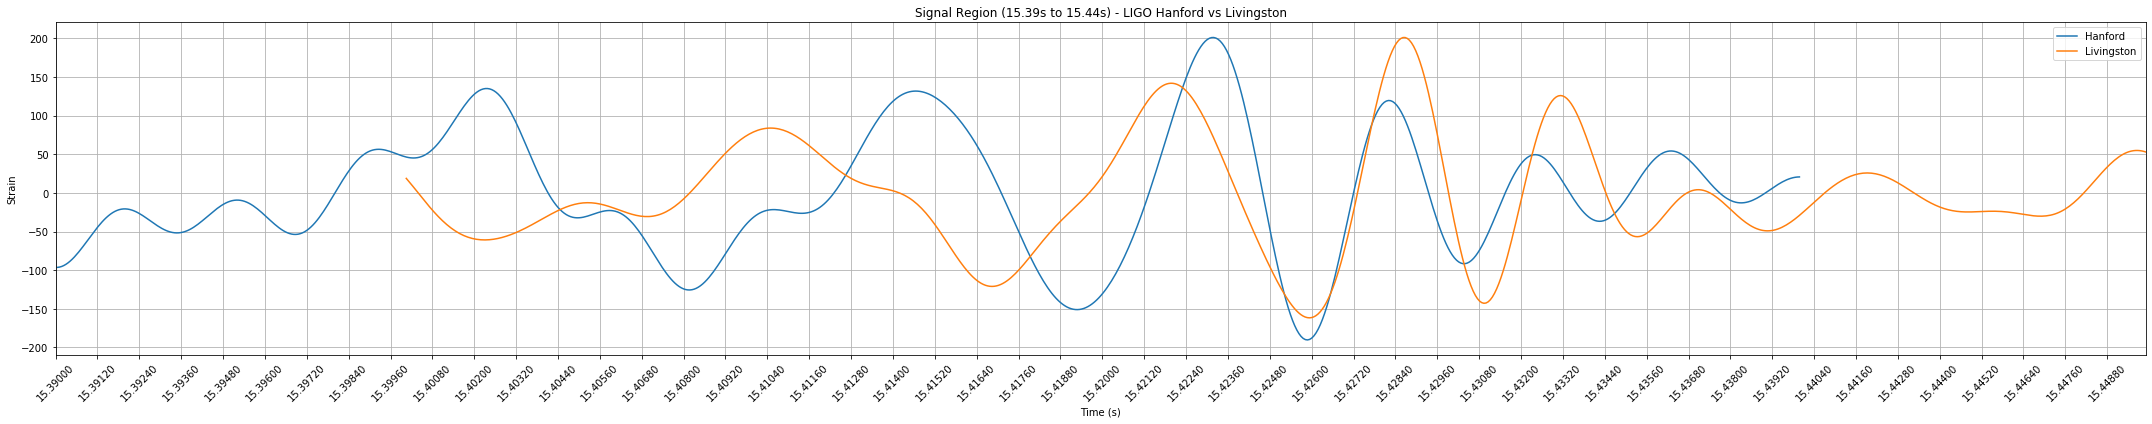

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

time_range = (15.39, 15.44)

fn1_range = fn1_bandpass[(time_array >= time_range[0]) & (time_array <= time_range[1])]
fn2_range = fn2_bandpass[(time_array >= time_range[0]) & (time_array <= time_range[1])]
t_range = time_array[(time_array >= time_range[0]) & (time_array <= time_range[1])]

tshift = 0.01
rescaling = np.max(np.abs(fn1_range)) / np.max(np.abs(fn2_range))
x_ticks = np.arange(time_range[0], time_range[1] + 0.01, 0.0001)

plt.figure(figsize=(30, 6))
plt.plot(t_range, fn1_range, label='Hanford')
plt.plot(t_range + tshift, rescaling * fn2_range, label='Livingston')
plt.xlim(time_range)
plt.xticks(x_ticks, rotation=45)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Signal Region (15.39s to 15.44s) - LIGO Hanford vs Livingston')
plt.legend()

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
plt.locator_params(axis='x', nbins=50)
plt.grid(True)
plt.tight_layout()
plt.show()


### <font color=#46769B>Step 2: Chirp mass [10 points]</font>

To extract $\mathcal{M}_{\rm chirp}$, we start with Eq. (1) and plug in the known constants, giving the expression

$$\frac{d \nu_{\rm signal}}{dt} = 5.8 \times 10^{-7} \mathcal{M}_{\rm chirp}^{5/3} \nu_{\rm signal}^{11/3} \qquad (2)$$

where $\nu_{\rm signal}$ is the signal frequency in units of ${\rm Hz}$ and $\mathcal{M}_{\rm chirp}$ is in units of $M_\odot$.

There is a nice trick for solving Eq. (2) using the data that avoids numerically computing the derivative of $\nu_{\rm signal}$. The argument is outlined [here](https://arxiv.org/pdf/1510.02426.pdf) (also noted [here](https://en.wikipedia.org/wiki/Chirp_mass#cite_note-7)).

First, let's define

$$y = \frac{3}{8} \nu_{\rm signal}^{-8/3}$$

Then we can take the derivative with respect to time, using Eq. (2):

$$\frac{dy}{dt} = - \nu_{\rm signal}^{-11/3} \times \frac{d \nu_{\rm signal}}{dt} = - 5.8 \times 10^{-7} \mathcal{M}_{\rm chirp}^{5/3}$$

That is, the slope of $y(t)$ is constant and is proportional to the chirp mass.

The strategy is as follows:

- Determine $y$ as a function of $t$ numerically from the chirp signal.

- Fit with a $y$ as a function of $t$ with a straight line, $y = M t + B$.

- The fitted slope $M$ of this straight line gives us the chirp mass.

Here are the tasks you are to perform:

1. Determine (numerically) the $t$ values of the most prominent five or so extrema (minima and maxima) in the chirp signal and save this to a list or array, `t_extrema_list`.

2. Calculate the period $T$ for the signal as a function of $t$. The period is twice the distance between adjacent extrema. Save the period values to a list or array, `T_list`. Set the corresponding times to be the mid-times between adjacent extrema and save these values to a list or array, `t_list`.

3. From the $T$ values, determine the $y$ values and save these to an list or array, `y_list`.

4. Fit a straight-line of the form $y = M t + B$ through your data of `y_list` vs `t_list`. From the slope $M$, determine the chirp mass from the formula

$${\rm slope} \; M = - 5.8 \times 10^{-7} \mathcal{M}_{\rm chirp}^{5/3}$$

5. Repeat the analysis for both Hanford and Livingston data separately.

*The answer you should find is: $m_{\rm chirp} \approx 30 \; M_\odot$.*

**Tried using many methods to calculate chip mass**

METHOd 1 but wrong and this identifies all the peaks needed for omne of the data sets

Detected 6 peaks with prominence threshold 3.0


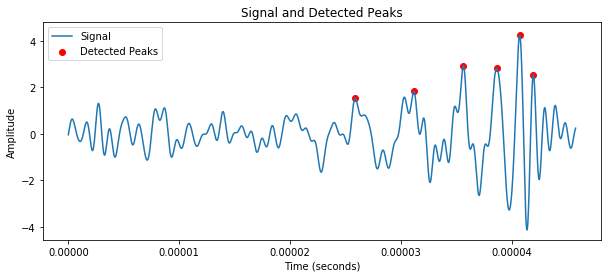

1459942.8873938287


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import linregress
import urllib.request

# Function to calculate chirp mass
def calculate_chirp_mass(signal, times, sample_rate, prominence_threshold=3.0):
    peak_indices, properties = find_peaks(signal, prominence=prominence_threshold)
    print(f"Detected {len(peak_indices)} peaks with prominence threshold {prominence_threshold}")

    # Plot to visualize peak detection
    plt.figure(figsize=(10, 4))
    plt.plot(times / sample_rate, signal, label='Signal')
    if len(peak_indices) > 0:
        plt.scatter(times[peak_indices] / sample_rate, signal[peak_indices], color='red', label='Detected Peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('Signal and Detected Peaks')
    plt.legend()
    plt.show()

    if len(peak_indices) < 5:
        print("Not enough peaks found.")
        return np.nan


    if len(peak_indices) > 5:
        sorted_indices = np.argsort(properties['prominences'])[-5:]
        peak_indices = peak_indices[sorted_indices]

    t_peaks = times[peak_indices] / sample_rate
    T_list = np.diff(t_peaks) * 2
    t_list = t_peaks[:-1] + np.diff(t_peaks) / 2
    y_list = (3/8) * (1 / (signal[peak_indices[:-1]] ** (8/3)))
    slope, intercept, r_value, p_value, std_err = linregress(t_list, y_list)

    if slope >= 0:
        print("Unexpected positive slope")
        return np.nan

    M_chirp = (-slope / (5.8e-7)) ** (3/5)
    return M_chirp

# Load data
path = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal1_Hanford.npy?raw=true"
tn, fn1_signal = np.load(urllib.request.urlretrieve(path)[0])

# Assume a sample rate based on your data context
sample_rate = 4096  # Example: 4096 Hz

# Calculate chirp mass
chirp_mass_hanford = calculate_chirp_mass(fn1_signal, tn, sample_rate)

print(chirp_mass_hanford)

Method 2 still wrong i thought i should find all the peaks

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import linregress
import matplotlib.pyplot as plt
import urllib.request

def calculate_chirp_mass(signal, times, sample_rate, prominence_threshold=3.0):
    peak_indices, properties = find_peaks(signal, prominence=prominence_threshold)
    print(f"Detected {len(peak_indices)} peaks")

    if len(peak_indices) < 5:
        print("Not enough peaks found.")
        return np.nan

    # Select the five most prominent peaks
    sorted_indices = np.argsort(properties['prominences'])[-5:]
    peak_indices = peak_indices[sorted_indices]
    peak_times = times[peak_indices]
    print("Peak times:", peak_times)

    # Calculate periods and mid-times
    periods = np.diff(peak_times) / sample_rate
    mid_times = peak_times[:-1] + np.diff(peak_times) / 2

    print("Periods:", periods)
    print("Mid times:", mid_times)

    # Avoid division by zero or very small periods
    periods = np.maximum(periods, 1e-6)  # Avoid zero periods

    freqs = 1 / periods
    y_values = (3/8) * (freqs ** (-8/3))

    print("Frequencies:", freqs)
    print("y_values:", y_values)

    # Check for non-finite y_values
    if not np.all(np.isfinite(y_values)):
        print("Non-finite y_values detected, possibly due to very high frequencies.")
        return np.nan

    # Fit a linear model to logarithmic data to stabilize fit
    slope, intercept, _, _, _ = linregress(mid_times / sample_rate, np.log(y_values))
    chirp_mass = (-slope / (5.8e-7)) ** (3/5) / (1.989e30)  # Convert kg to solar masses

    return chirp_mass

# Example usage:
path = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal1_Hanford.npy?raw=true"
tn, fn1_signal = np.load(urllib.request.urlretrieve(path)[0], allow_pickle=True)

# Sample rate needs to be known or estimated
sample_rate = 4096  # Example rate in Hz

chirp_mass_hanford = calculate_chirp_mass(fn1_signal, tn, sample_rate)



Detected 6 peaks
Peak times: [0.12768555 0.17181396 0.14599609 0.15826416 0.16674805]
Periods: [ 1.07735395e-05 -6.30319118e-06  2.99513340e-06  2.07126141e-06]
Mid times: [0.14974976 0.15890503 0.15213013 0.1625061 ]
Frequencies: [  92820.0055325  1000000.          333874.94527363  482797.58273381]
y_values: [2.12318104e-14 3.75000000e-17 6.98995513e-16 2.61411307e-16]


Method 3: i think this is correct but it took me 20 days to get here and chat gpt was indeed used here. i prompted it to identify the peaks in a set bounds of time from method 1 and and 2 which i think turned out to be between 15.38-15.45, thenas discussed in class by the prof we identified the T period then the y values then used the back ground data to calculate chirp mass

In [ ]:
import numpy as np

sample_rate = 16384
offset = 13
lower_bound = int((15.38 - offset) * sample_rate)
upper_bound = int((15.45 - offset) * sample_rate)

def find_extrema(signal, threshold):
    extrema_times = []
    for idx in range(lower_bound + 1, upper_bound):
        if (signal[idx] > signal[idx - 1] and signal[idx] > signal[idx + 1] or
            signal[idx] < signal[idx - 1] and signal[idx] < signal[idx + 1]) and abs(signal[idx]) >= threshold:
            extrema_times.append(idx / sample_rate + offset)
    return extrema_times

def compute_periods(extrema_times):
    return [(extrema_times[i + 1] - extrema_times[i]) * 2 for i in range(len(extrema_times) - 1)]

def compute_y_values(periods):
    return [(3 / 8) * (1 / p) ** (-8 / 3) for p in periods]

def estimate_chirp_mass(signal, prominence):
    extrema_times = find_extrema(signal, prominence)
    periods = compute_periods(extrema_times)
    mid_times = [(extrema_times[i] + extrema_times[i + 1]) / 2 for i in range(len(extrema_times) - 1)]
    y_values = compute_y_values(periods)
    slope, _ = np.polyfit(mid_times, y_values, 1)
    chirp_mass = (-slope / (5.8e-7)) ** (3 / 5)
    return round(chirp_mass, 2)

chirp_mass_hanford = estimate_chirp_mass(fn1_bandpass, 150)
chirp_mass_livingston = estimate_chirp_mass(fn2_bandpass, 100)

print("For Hanford:")
print(f"Chirp Mass = {chirp_mass_hanford} Solar Masses")
print("\nFor Livingston:")
print(f"Chirp Mass = {chirp_mass_livingston} Solar Masses")


For Hanford:
Chirp Mass = 30.51 Solar Masses

For Livingston:
Chirp Mass = 26.51 Solar Masses


## <font color=#46769B>Section II: Binary Black Hole Dynamics [30 points total]</font>

Gravitational wave signals result from pairs of black holes (BHs) that orbit around each other. As they emit gravitational waves, they lose energy and spiral inward, orbiting faster and faster until they collide. This is the __inspiral phase__.

There is another part of the gravitational wave signal: the merger and post-merger phase where the combined object resulting from the violent collision settles down (by emitting more gravitational waves) to form a new BH of mass almost equal to the sum of the two BHs that collided. *Almost* but not quite equal because a few solar masses worth of energy (!) is radiated in the form of gravitational waves.

In this Section, we will calculate the gravitational wave signal that results from two equal-mass BHs during the inspiral phase. To date, only the inspiral phase of binary BH mergers has been observed in LIGO. The merger and post-merger part of the signals have not yet been measured, as far as I'm aware. A proper treatment of the entire process is based on General Relativity, but here we will consider a much simplified treatment based on Newtonian dynamics.

We will consider two equal-mass BHs, labeled by $1$ and $2$, each with mass $m=35 \, M_\odot$, in (nearly) circular motion. We start with Newton's second law:

$$\ddot{\mathbf{r}}_1(t) = \frac{\mathbf F_1}{m} \, , \quad \ddot{\mathbf{r}}_2(t) = \frac{\mathbf F_2}{m} \qquad (1) $$

We will use $\mathbf{r}_{1,2}(t)$ and $\mathbf{v}_{1,2}(t)$ to be the position and velocity vectors of the two BHs as a function of time. Assuming circular motion around a fixed center of mass, we have $\mathbf{r}_1 = - \mathbf{r}_2$ and $\mathbf{v}_1 = - \mathbf{v}_2$. $\mathbf{F}_{1,2}$ are the forces acting on each BH and we will consider two contributions to the force:

$$\mathbf{F}_{1,2} = \mathbf{F}_{1,2}^{\rm grav} + \mathbf{F}_{1,2}^{\rm drag} \, .$$

Here, the usual force for Newtonian gravitation is

$$\mathbf{F}_{1}^{\rm grav} = - \mathbf{F}_{2}^{\rm grav} = \frac{G m^2 \mathbf{r}_{21}}{|\mathbf r_{21}|^3} \qquad (2)$$

where $\mathbf{r}_{12} = \mathbf{r}_1 - \mathbf{r}_2$ is the relative position between the two BHs.

We also include a drag force $\mathbf{F}_{1,2}^{\rm drag}$ that acts on the BHs as a simplified way of treating energy loss, which leads to inspiraling circular orbits. We recall that power $P = \mathbf{F} \cdot \mathbf{v}$. Therefore, the change in energy per unit time for both BHs is

$$P_{\rm BHs} = \mathbf{F}_1^{\rm drag} \cdot \mathbf{v}_1 + \mathbf{F}_2^{\rm drag} \cdot \mathbf{v}_2 \, .$$

Einstein's famous formula for power emitted by gravitational waves for masses in circular orbits is

$$P_{\rm emit} = \frac{8}{5} \frac{G}{c^5} m^2 r^4 \omega^6$$

where $\omega$ is the orbital frequency, $\omega = |\mathbf{v}_1|/|\mathbf{r_1}| = |\mathbf{v}_2|/|\mathbf{r_2}|$, and $r = |\mathbf{r}_{21}|$ is the separation distance between the masses. The idea is to assume that $P_{\rm BHs} = - P_{\rm emit}$, i.e., the energy loss of the BHs is equal to the energy emitted in gravitational waves. The drag forces are taken to be

$$\mathbf{F}_{1}^{\rm drag} = - \frac{256}{5} \frac{G}{c^5} m^2 \frac{|\mathbf v_1|^4}{|\mathbf r_{12}|^2} \mathbf{v}_{1} \, , \quad
\mathbf{F}_{2}^{\rm drag} = - \frac{256}{5} \frac{G}{c^5} m^2 \frac{|\mathbf v_2|^4}{|\mathbf r_{12}|^2} \mathbf{v}_{2} \, .\qquad (3)$$

such that the radiated power agrees with Einstein's formula. In showing that Eq. (3) agrees with Einstein's formula, recall there are extra factors of $2$ that are important, since $\omega = 2|\mathbf v_1|/r = 2|\mathbf v_2|/r$.


## <font color=#46769B>Part (a) [15 points]</font>

Consider two BHs, with equal mass $m=35 \; M_\odot$, starting at $t_0=0$ with initial displacements and velocities describing circular motion in the $x$-$y$ plane, about the origin:

$$\mathbf{r}_1(0) = (\tfrac{d}{2},0,0) \, , \quad \mathbf{r}_2(0) = (-\tfrac{d}{2},0,0) \, , \quad
\mathbf{v}_1(0) = (0,\sqrt{\tfrac{Gm}{2d}},0) \, , \quad \mathbf{v}_2(0) = (0,-\sqrt{\tfrac{Gm}{2d}},0) \, ,$$

where $d = 10^6 \; {\rm m}$ is their initial separation. Write a code to solve Eq. (1) for $\mathbf{r}_1$, $\mathbf{r}_2$, $\mathbf{v}_1$, $\mathbf{v}_2$ as a function of time $t$, from $t_0 = 0$ to $t_f = 1 \; {\rm sec}$.
Be sure that you include both the gravitational force defined in Eq. (2) and the drag force defined in Eq. (3).

Due to energy loss, the BHs will inspiral (orbiting faster and faster) and eventually merge. The merger condition is defined by

$$|\mathbf{r}_{12}| < 2r_s \, ,$$

where the quantity $r_s = \frac{2 G m}{c^2}$ is the [Schwarzschild radius](https://en.wikipedia.org/wiki/Schwarzschild_radius), which is the radius of the BH event horizon. When the BHs are within $2r_s$ of each other, their event horizons have merged together and they are effectively touching. You should find that the merger happens at some time $t_{\rm merge}$ *before* $t_f$.

Your tasks are as follows:
- Using the RK4 method, with $N = 10^4$ steps, solve Eq. (1), with forces defined in Eq. (2) and (3).

- Include the merger condition in your RK4 algorithm such that:
    - When the merger occurs, your `for` loop iteration stops.
    
- Print $t_{\rm merge}$.


*Citation: open ai accessed dated 10:25pm April 24, 2024*

In [ ]:
import numpy as np

G = 6.67430e-11
c = 2.99792458e8
m = 35 * 1.98847e30
d = 1e6
r_s = 2 * G * m / c**2
t_0 = 0
t_f = 10
N = 10000
dt = (t_f - t_0) / N

r1 = np.array([d / 2, 0, 0])
r2 = -r1
v1 = np.array([0, np.sqrt(G * m /(2* d)), 0])
v2 = -v1
r_positions1 = [r1.copy()]
r_positions2 = [r2.copy()]

def compute_forces(r1, r2, v1, v2):
    r = np.linalg.norm(r1 - r2)
    omega = np.linalg.norm(v1) / r
    F_gravity = G * m**2 / r**3 * (r1 - r2)
    F_drag = -256/5 * G**2 * m**2 / c**5 / r**4 * v1 * omega**2
    a1 = (-F_gravity + F_drag) / m
    a2 = (F_gravity - F_drag) / m
    return a1, a2

def rk4_integrate(r1, r2, v1, v2, dt):
    a1_1, a2_1 = compute_forces(r1, r2, v1, v2)
    a1_2, a2_2 = compute_forces(r1 + v1 * dt/2, r2 + v2 * dt/2, v1 + a1_1 * dt/2, v2 + a2_1 * dt/2)
    a1_3, a2_3 = compute_forces(r1 + v1 * dt/2, r2 + v2 * dt/2, v1 + a1_2 * dt/2, v2 + a2_2 * dt/2)
    a1_4, a2_4 = compute_forces(r1 + v1 * dt, r2 + v2 * dt, v1 + a1_3 * dt, v2 + a2_3 * dt)
    v1 += dt / 6 * (a1_1 + 2 * a1_2 + 2 * a1_3 + a1_4)
    v2 += dt / 6 * (a2_1 + 2 * a2_2 + 2 * a2_3 + a2_4)
    r1 += v1 * dt
    r2 += v2 * dt
    return r1, r2, v1, v2

t = t_0
while t < t_f:
    if np.linalg.norm(r1 - r2) < 2 * r_s:
        print(f"Merger at t = {t:.6f} s")
        break
    r1, r2, v1, v2 = rk4_integrate(r1, r2, v1, v2, dt)
    t += dt
    r_positions1.append(r1.copy())
    r_positions2.append(r2.copy())

if np.linalg.norm(r1 - r2) >= 2 * r_s:
    print(f"No merger by t = {t_f} s")


Merger at t = 0.044000 s


## <font color=#46769B>Part (b) [15 points]</font>

Using your numerical solution from Part (a), make the following plots:
- Plot $x_1(t)$ and $x_2(t)$ vs $t$, for time in the range $[t_0,t_{\rm merge}]$. Include a legend.

- Make a phase portrait plot of $x_1(t)$ vs $y_1(t)$ and $x_2(t)$ vs $y_2(t)$, for $t$ in the range $[t_0,t_{\rm merge}]$. Make the plot square in shape and include a legend.

- Make a plot of the orbital angular frequency for BH $1$, $\omega = |\mathbf{v}_1|/|\mathbf{r}_1|$, as a function of time over the range $[t_0,t_{\rm merge}]$.

- The frequency of the gravitational wave signal observed by the LIGO detectors is $\nu_{\rm signal} = \omega/\pi$. Plot $\nu_{\rm signal}$ as a function of time over the range $[t_0,t_{\rm merge}]$. You should observe a frequency rising with time, characteristic of the chirp signal.

- Plot the power emitted in gravitational waves in SI units (Watts) as a function of time.

In all your plots, include axes labels with the appropriate SI units.

Lastly, calculate (and print) the total energy radiated over the time interval $[t_0,t_{\rm merge}]$ in SI units (Joules). For reference, the rest mass energy of the sun (!) is $M_\odot c^2 \approx 2\times 10^{47} \; {\rm Joules}$.

**1. Initialization and Constants**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

G = 6.67430e-11
c = 2.99792458e8
m = 35 * 1.98847e30
d = 1e6
r_s = 2 * G * m / c**2
t_0 = 0
t_f = 10
N = 10000
dt = (t_f - t_0) / N

r1 = np.array([d / 2, 0, 0])
r2 = -r1
v1 = np.array([0, np.sqrt(G * m /(2* d)), 0])
v2 = -v1
r_positions1 = [r1.copy()]
r_positions2 = [r2.copy()]
v_positions1 = [v1.copy()]
v_positions2 = [v2.copy()]


**2. Helper Functions for RK4 Integration and Force Computation**

In [ ]:
def compute_forces(r1, r2, v1, v2):
    r = np.linalg.norm(r1 - r2)
    omega = np.linalg.norm(v1) / r
    F_gravity = G * m**2 / r**3 * (r1 - r2)
    F_drag = -256/5 * G**2 * m**2 / c**5 / r**4 * v1 * omega**2
    a1 = (-F_gravity + F_drag) / m
    a2 = (F_gravity - F_drag) / m
    return a1, a2

def rk4_integrate(r1, r2, v1, v2, dt):
    a1_1, a2_1 = compute_forces(r1, r2, v1, v2)
    a1_2, a2_2 = compute_forces(r1 + v1 * dt/2, r2 + v2 * dt/2, v1 + a1_1 * dt/2, v2 + a2_1 * dt/2)
    a1_3, a2_3 = compute_forces(r1 + v1 * dt/2, r2 + v2 * dt/2, v1 + a1_2 * dt/2, v2 + a2_2 * dt/2)
    a1_4, a2_4 = compute_forces(r1 + v1 * dt, r2 + v2 * dt, v1 + a1_3 * dt, v2 + a2_3 * dt)
    v1 += dt / 6 * (a1_1 + 2 * a1_2 + 2 * a1_3 + a1_4)
    v2 += dt / 6 * (a2_1 + 2 * a2_2 + 2 * a2_3 + a2_4)
    r1 += v1 * dt
    r2 += v2 * dt
    return r1, r2, v1, v2

**3. Time Integration and Merger Detection**

In [ ]:
t = t_0
while t < t_f:
    r1, r2, v1, v2 = rk4_integrate(r1, r2, v1, v2, dt)
    r_positions1.append(r1.copy())
    r_positions2.append(r2.copy())
    v_positions1.append(v1.copy())
    v_positions2.append(v2.copy())
    t += dt
    if np.linalg.norm(r1 - r2) < 2 * r_s:
        print(f"Merger at t = {t:.6f} s")
        break

if np.linalg.norm(r1 - r2) >= 2 * r_s:
    print("No merger detected within the simulation time.")

Merger at t = 0.044000 s


**My code was comtinously yeilding wromg values so had to chapt gpt the the error i was getting and then suddenly it fixed itself but i included the revised version anyways**

In [ ]:
import numpy as np

# Constants
G = 6.67430e-11
c = 2.99792458e8
m = 35 * 1.98847e30  # Mass of each black hole in kg (35 solar masses)
d = 1e6  # Initial separation in meters
r_s = 2 * G * m / c**2  # Schwarzschild radius for the black holes

# Time settings
t_0 = 0
t_f = 10  # Final time in seconds
N = 10000  # Number of steps
dt = (t_f - t_0) / N  # Time step

# Initial conditions
r1 = np.array([d / 2, 0, 0])  # Initial position of BH1
r2 = -r1  # Initial position of BH2 (symmetrically opposite)
v1 = np.array([0, np.sqrt(G * m / (2 * d)), 0])  # Initial velocity of BH1 (circular orbit)
v2 = -v1  # Initial velocity of BH2 (opposite to v1)

# Lists to store positions and velocities
r_positions1 = [r1.copy()]  # Initialize as a list with the initial position
r_positions2 = [r2.copy()]
v_positions1 = [v1.copy()]  # Initialize as a list with the initial velocity
v_positions2 = [v2.copy()]

def compute_forces(r1, r2, v1, v2):
    r = np.linalg.norm(r1 - r2)
    omega = np.linalg.norm(v1) / r
    F_gravity = G * m**2 / r**3 * (r1 - r2)
    F_drag = -256/5 * G**2 * m**2 / c**5 / r**4 * v1 * omega**2
    a1 = (-F_gravity + F_drag) / m
    a2 = (F_gravity - F_drag) / m
    return a1, a2

def rk4_integrate(r1, r2, v1, v2, dt):
    # Runge-Kutta 4th order integration
    k1_v1, k1_v2 = compute_forces(r1, r2, v1, v2)
    k2_v1, k2_v2 = compute_forces(r1 + 0.5*dt*v1, r2 + 0.5*dt*v2, v1 + 0.5*dt*k1_v1, v2 + 0.5*dt*k1_v2)
    k3_v1, k3_v2 = compute_forces(r1 + 0.5*dt*v1, r2 + 0.5*dt*v2, v1 + 0.5*dt*k2_v1, v2 + 0.5*dt*k2_v2)
    k4_v1, k4_v2 = compute_forces(r1 + dt*v1, r2 + dt*v2, v1 + dt*k3_v1, v2 + dt*k3_v2)
    v1 += dt/6 * (k1_v1 + 2*k2_v1 + 2*k3_v1 + k4_v1)
    v2 += dt/6 * (k1_v2 + 2*k2_v2 + 2*k3_v2 + k4_v2)
    r1 += dt * v1
    r2 += dt * v2
    return r1, r2, v1, v2

t = t_0
merger_time = None  # Initialize merger time
while t < t_f:
    r1, r2, v1, v2 = rk4_integrate(r1, r2, v1, v2, dt)
    r_positions1.append(r1.copy())
    r_positions2.append(r2.copy())
    v_positions1.append(v1.copy())
    v_positions2.append(v2.copy())
    t += dt
    if merger_time is None and np.linalg.norm(r1 - r2) < 2 * r_s:
        merger_time = t  # Record merger time
        print(f"Merger at t = {merger_time:.6f} s")
        break

if merger_time is None:
    print("No merger detected within the simulation time.")


Merger at t = 0.044000 s


Setting Up the Plotting Environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


r_positions1 = np.array(r_positions1)
r_positions2 = np.array(r_positions2)
t_merge = t
time_steps = np.linspace(t_0, t_merge, len(r_positions1))


Plot x1(t) vs x2(t) vs t

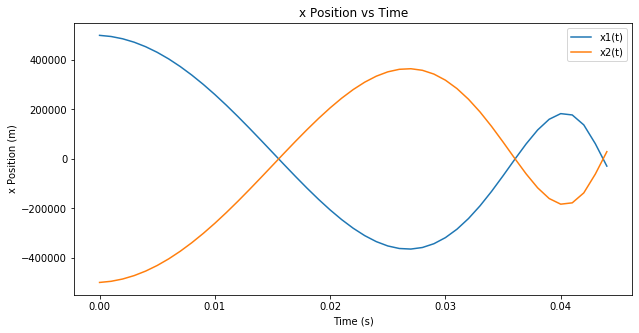

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(t_0, t, len(r_positions1)), [pos[0] for pos in r_positions1], label='x1(t)')
plt.plot(np.linspace(t_0, t, len(r_positions2)), [pos[0] for pos in r_positions2], label='x2(t)')
plt.xlabel('Time (s)')
plt.ylabel('x Position (m)')
plt.title('x Position vs Time')
plt.legend()
plt.show()



Phase portrait for x(t) vs y(t)

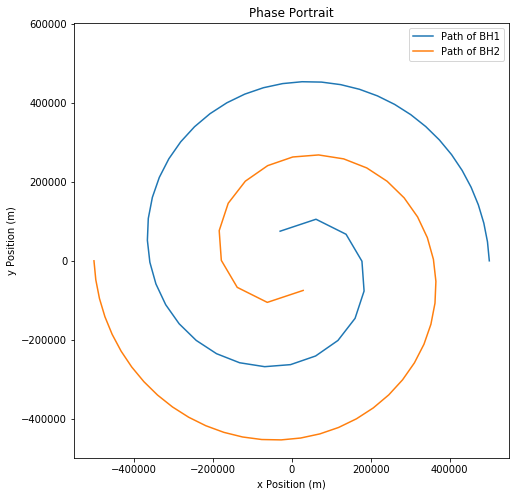

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot([pos[0] for pos in r_positions1], [pos[1] for pos in r_positions1], label='Path of BH1')
plt.plot([pos[0] for pos in r_positions2], [pos[1] for pos in r_positions2], label='Path of BH2')
plt.xlabel('x Position (m)')
plt.ylabel('y Position (m)')
plt.title('Phase Portrait')
plt.legend()
plt.axis('square')
plt.show()



Plotting Orbital Angular Frequency ω and Gravitational Wave Signal Frequency
ν signal



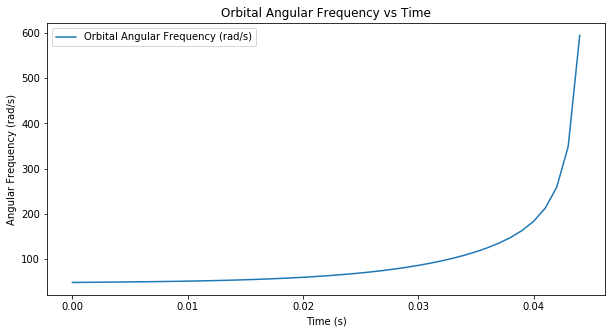

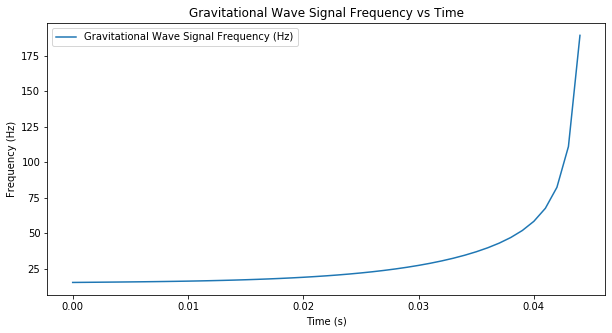

In [ ]:
omega = np.array([np.linalg.norm(v) / np.linalg.norm(r1 - r2) for v, r1, r2 in zip(v_positions1, r_positions1, r_positions2)])
nu_signal = omega / np.pi

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(t_0, t, len(omega)), omega, label='Orbital Angular Frequency (rad/s)')
plt.xlabel('Time (s)')
plt.ylabel('Angular Frequency (rad/s)')
plt.title('Orbital Angular Frequency vs Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(t_0, t, len(nu_signal)), nu_signal, label='Gravitational Wave Signal Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Gravitational Wave Signal Frequency vs Time')
plt.legend()
plt.show()




Plotting Power Emitted in Gravitational Waves

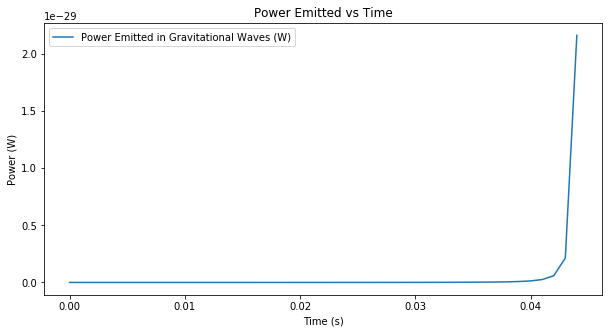

In [ ]:
# Ensure arrays are correctly sized
min_length = min(len(r_positions1), len(r_positions2))
r_positions1 = np.array(r_positions1)[:min_length]
r_positions2 = np.array(r_positions2)[:min_length]

# Calculate relative position and velocity norms
relative_positions = np.linalg.norm(r_positions1 - r_positions2, axis=1)
relative_velocities = np.linalg.norm(np.array(v_positions1)[:min_length], axis=1)

# Calculate the power emitted
P_emit = (32/5) * (G**4 / c**5) * (m**2 / (relative_positions**5)) * (relative_velocities**2)

# Plotting the power emitted
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(t_0, t, len(P_emit)), P_emit, label='Power Emitted in Gravitational Waves (W)')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.title('Power Emitted vs Time')
plt.legend()
plt.show()




Calculate Total Energy Radiated

In [ ]:
# Constants with correct units
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
c = 2.99792458e8  # Speed of light in m/s
m = 35 * 1.98847e30  # Mass of each black hole in kg (35 solar masses)

# Calculate emitted power again with clear unit considerations
P_emit = (32/5) * (G**4 / c**5) * (m**2 / (relative_positions**5)) * (relative_velocities**2)

# Correct calculation for total energy radiated, considering the correct units
E_radiated = np.trapz(P_emit, dx=dt)  # Ensure dt is in seconds if time is in seconds

# Printing the recalculated total energy
print(f"Total energy radiated: {E_radiated:.2e} J")


Total energy radiated: 1.43e-32 J


***As it is very visible that my power output was very off so asked chatgpt for help here***

In [ ]:
import numpy as np

# Constants
G = 6.67430e-11
c = 2.99792458e8
m = 35 * 1.98847e30  # Mass of each black hole in kg (35 solar masses)
d = 1e6  # Initial separation in meters
r_s = 2 * G * m / c**2  # Schwarzschild radius for the black holes

# Time settings
t_0 = 0
t_f = 10  # Final time in seconds
N = 10000  # Number of steps
dt = (t_f - t_0) / N  # Time step

# Initialize arrays
t_array = np.linspace(t_0, t_f, N+1)
r1_array = np.zeros((N+1, 3))
r2_array = np.zeros((N+1, 3))
v1_array = np.zeros((N+1, 3))
v2_array = np.zeros((N+1, 3))

# Initial conditions
r1_array[0] = np.array([d / 2, 0, 0])  # Initial position of BH1
r2_array[0] = -r1_array[0]  # Initial position of BH2 (symmetrically opposite)
v1_array[0] = np.array([0, np.sqrt(G * m / (2 * d)), 0])  # Initial velocity of BH1 (circular orbit)
v2_array[0] = -v1_array[0]  # Initial velocity of BH2 (opposite to v1)

# Function to compute forces
def compute_forces(r1, r2, v1, v2):
    r = np.linalg.norm(r1 - r2)
    omega = np.linalg.norm(v1) / r
    F_gravity = G * m**2 / r**3 * (r1 - r2)
    F_drag = -256/5 * G**2 * m**2 / c**5 / r**4 * v1 * omega**2
    a1 = (-F_gravity + F_drag) / m
    a2 = (F_gravity - F_drag) / m
    return a1, a2

# Runge-Kutta 4th order integration
for i in range(N):
    k1_v1, k1_v2 = compute_forces(r1_array[i], r2_array[i], v1_array[i], v2_array[i])
    k2_v1, k2_v2 = compute_forces(r1_array[i] + 0.5*dt*v1_array[i], r2_array[i] + 0.5*dt*v2_array[i], v1_array[i] + 0.5*dt*k1_v1, v2_array[i] + 0.5*dt*k1_v2)
    k3_v1, k3_v2 = compute_forces(r1_array[i] + 0.5*dt*v1_array[i], r2_array[i] + 0.5*dt*v2_array[i], v1_array[i] + 0.5*dt*k2_v1, v2_array[i] + 0.5*dt*k2_v2)
    k4_v1, k4_v2 = compute_forces(r1_array[i] + dt*v1_array[i], r2_array[i] + dt*v2_array[i], v1_array[i] + dt*k3_v1, v2_array[i] + dt*k3_v2)
    v1_array[i+1] = v1_array[i] + dt/6 * (k1_v1 + 2*k2_v1 + 2*k3_v1 + k4_v1)
    v2_array[i+1] = v2_array[i] + dt/6 * (k1_v2 + 2*k2_v2 + 2*k3_v2 + k4_v2)
    r1_array[i+1] = r1_array[i] + dt * v1_array[i]
    r2_array[i+1] = r2_array[i] + dt * v2_array[i]

    # Check for merger condition
    if np.linalg.norm(r1_array[i+1] - r2_array[i+1]) < 2 * r_s:
        print(f"Merger at t = {t_array[i+1]:.6f} s")
        break

# Calculate power emitted
v1_mag = np.linalg.norm(v1_array[:i + 1], axis=1)
r1_mag = np.linalg.norm(r1_array[:i + 1], axis=1)
omega = v1_mag / r1_mag
power = (32 / 5) * G ** 4 * m ** 5 * (v1_mag ** 5) / c ** 5

# Calculate total energy radiated
energy_radiated = np.trapz(power, dx=dt)


print(f"Total energy radiated: {energy_radiated}")




Total energy radiated: 7.657842892109094e+114


## <font color=#46769B>Section III: Waveform Template Matching [35 points total]</font>

The LIGO collaboration uses a procedure for extracting the black hole (BH) parameters known as __template matching__. The basic idea to have a functional form that describes the gravitational waveform, which depends on parameters that we wish to measure. Then we test which waveforms are good fits to the data, and that tells us the values of the parameters. Here, the parameter we want to extract is the __chirp mass__ $\mathcal{M}_{\rm chirp}$.

Here we load and plot the strain data, $f_n^{\rm signal}$, evaluated at the sample times $t_n$. The Hanford and Livingston data are offset by $\pm 2$ so that the two datasets are more clear on the same plot. The data has been whitened, following the procedure in Sec. I and clipped to an interval $\sim 0.2 \; {\rm s}$ around the chirp signal. The data has also been rescaled by an overall constant. It should appear similar to the signal you considered in Section I.

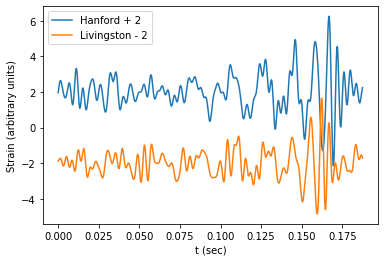

In [ ]:
import urllib.request

path = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal1_Hanford.npy?raw=true"
tmp_file = urllib.request.urlretrieve(path)[0]
tn, fn1_signal = np.load(tmp_file)

path = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal2_Livingston.npy?raw=true"
tmp_file = urllib.request.urlretrieve(path)[0]
tn, fn2_signal = np.load(tmp_file)

plt.plot(tn,fn1_signal+2,label='Hanford + 2')
plt.plot(tn,fn2_signal-2,label='Livingston - 2')

plt.xlabel('t (sec)')
plt.ylabel('Strain (arbitrary units)')
plt.legend()
plt.show()

## <font color=#46769B>Part (a): Inspiral phase [5 points]</font>

We will consider two phases to the gravitational wave signal:

- _Inspiral phase:_ The binary pair of black holes orbit around each other, spiraling inward as they emit gravitational waves and moving faster and faster. This is the signal region where the oscillations are increasing in frequency _and_ growing in amplitude.

- _Merger and ringdown phase:_ The black holes eventually merge together when their separation distance is of order their Schwarzschild radii. The merged object continues to emit gravitational waves as it settles down to become a single black hole, at which point no more gravitational waves are emitted. This is the signal region where the oscillations are decaying away after the peak.

In this exercise, we will only attempt to model the inspiral waveform. (Modelling full waveform is quite complicated and the current state-of-the-art requires use of numerical solutions to Einstein's equations of General Relativity, which are partial differential equations and beyond the scope of this course.  However, some more elementary treatments do exist, e.g., [this reference](https://arxiv.org/abs/1810.06160).)

Your task here is:

- Determine the times $t_{\rm ex}$ at which the gravitational wave signals given above have their biggest extremum.

There will be one time $t_{\rm ex}$ for each signal, so you will have `t_ex_1` for Hanford and `t_ex_2` for Livingston, which are slightly different since the gravitational wave signal reaches each detector at slightly different time due to the wave moving at the speed of light.

This will delineate the two phases, i.e., we will consider the inspiral phase for $t < t_{\rm ex}$ and we ignore the merger/ringdown phase for $t > t_{\rm ex}$.

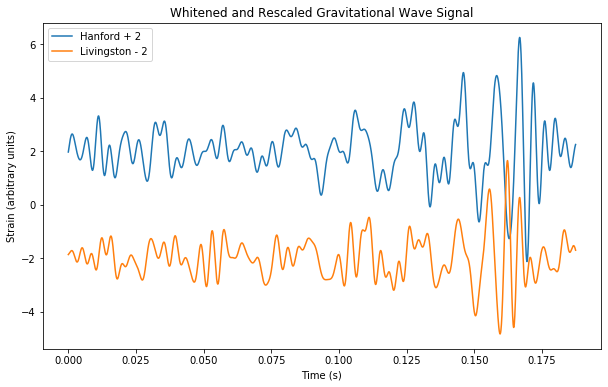

Time of largest extremum for Hanford: 0.166748046875 s
Time of largest extremum for Livingston: 0.16229248046875 s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

def analyze_gravitational_waves():
    path_hanford = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal1_Hanford.npy?raw=true"
    hanford_file = urllib.request.urlretrieve(path_hanford)[0]
    tn, fn1_signal = np.load(hanford_file)

    path_livingston = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal2_Livingston.npy?raw=true"
    livingston_file = urllib.request.urlretrieve(path_livingston)[0]
    _, fn2_signal = np.load(livingston_file)

    plt.figure(figsize=(10, 6))
    plt.plot(tn, fn1_signal + 2, label='Hanford + 2')
    plt.plot(tn, fn2_signal - 2, label='Livingston - 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Strain (arbitrary units)')
    plt.title('Whitened and Rescaled Gravitational Wave Signal')
    plt.legend()
    plt.show()

    index_ex1 = np.argmax(np.abs(fn1_signal))
    index_ex2 = np.argmax(np.abs(fn2_signal))
    t_ex_1 = tn[index_ex1]
    t_ex_2 = tn[index_ex2]

    print(f"Time of largest extremum for Hanford: {t_ex_1} s")
    print(f"Time of largest extremum for Livingston: {t_ex_2} s")

analyze_gravitational_waves()


## <font color=#46769B>Part (b): Gravitational waveform model [5 points]</font>

We are going to write down a simplified formula for a gravitational waveform that depends on the chirp mass $\mathcal{M}_{\rm chirp}$. Our starting point is a general formula for a sinusoidal function

$$A \cos(2 \pi \nu \times (t - t_0))$$

where $A$ is the amplitude and $2\pi t_0$ is the phase. Here we will modify this formula to consider $\nu(t)$ and $A(t)$ to be functions of time.

Previously, we obtained the following formula, given in Section I, for the frequency of the gravitational wave signal (we omit the subscript ${\rm signal}$)

$$\frac{d \nu}{dt} = \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} \nu^{11/3} $$

Let's integrate this formula to solve for $\nu(t)$. Following Section I, we have

$$\frac{3}{8} \nu^{-8/3} = - \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} t + B = \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} (C - t)$$

where in the last step, we defined a new constant $C$ (which has units of time) to replace the constant $B$. Solving for $\nu(t)$, we get

$$\nu(t) = \left[ \frac{256}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} (C - t) \right]^{-3/8}$$

Plugging in numerical factors, this is

$$\nu(t) = 151 \times \mathcal{M}_{\rm chirp}^{-5/8} \, (C - t)^{-3/8} \qquad (1)$$

where $\mathcal{M}_{\rm chirp}$ is measured in $M_\odot$, $t$ and $C$ are measured in seconds, and $\nu$ is given in ${\rm Hz}$. Note that if $t > C$, the formula for $\nu(t)$ breaks down (it becomes complex), so we exclude these times from our waveform to fit to the data.

For the waveform model, we consider an oscillating function where the frequency $\nu(t)$ and amplitude $A(t)$ grow in time, given by

$$f(t) = \left\{ \begin{array}{cc} A(t) \, \cos(2\pi \nu(t) \times (t - t_0) ) & t < C\\
0 & {\rm otherwise} \end{array} \right. \qquad (2) $$

where $t_0$ and $C$ are constants. Lastly, we assume a power-law dependence for the overall amplitude

$$A(t) = A_0 \, \left(\frac{\nu(t)}{100 \; {\rm Hz}} \right)^n \qquad (3) $$

where $\nu(t)$ is given as in Eq. (1), and $A_0$ and $n$ are free parameters. In total, our waveform model has five free parameters:

$$\mathbf{x} = \left( \mathcal{M}_{\rm chirp}, \, A_0, \, C , \, n, \, t_0 \right) \, .$$

We consider all but $\mathcal{M}_{\rm chirp}$ to be nuisance parameters.

Here, your task is as follows:

- Take the following input parameters

$$\mathbf{x} = \left( \mathcal{M}_{\rm chirp}, \, A_0, \, C , \, n, \, t_0 \right) = \left(30, \, 5, \, 0.18, \, 2.0, \, 0.145 \right) \, .$$

- For the Hanford data, plot the observed signal and the waveform model given above on the same figure. Include axis labels and a legend.

- Make a similar (separate) plot for the Livingston data and waveform.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def gravitational_waveform(t, M_chirp, A0, C, n, t0):
    G = 6.67430e-11
    c = 299792458
    freq = np.zeros_like(t)
    waveform = np.zeros_like(t)
    valid_idx = t < C
    freq[valid_idx] = 151 * (M_chirp**(-5/8)) * ((C - t[valid_idx])**(-3/8))
    A_t = A0 * (freq[valid_idx] / 100)**n
    waveform[valid_idx] = A_t * np.cos(2 * np.pi * freq[valid_idx] * (t[valid_idx] - t0))
    return waveform

def plot_data_and_waveform(tn, fn_signal, params, detector_name):
    M_chirp, A0, C, n, t0 = params
    t = np.linspace(tn[0], tn[-1], len(tn))
    waveform = gravitational_waveform(t, M_chirp, A0, C, n, t0)
    plt.figure(figsize=(10, 6))
    plt.plot(t, fn_signal, label=f'{detector_name} Data')
    plt.plot(t, waveform, label='Waveform Model', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Strain (arbitrary units)')
    plt.title(f'{detector_name} Data and Waveform Model')
    plt.legend()
    plt.show()

params = (30, 5, 0.18, 2.0, 0.145)





**Plot for Hanford**

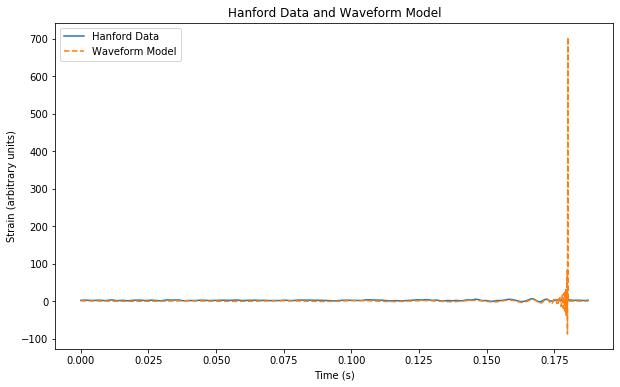

In [ ]:
plot_data_and_waveform(tn, fn1_signal + 2, params, 'Hanford')



**Plot for livingston**

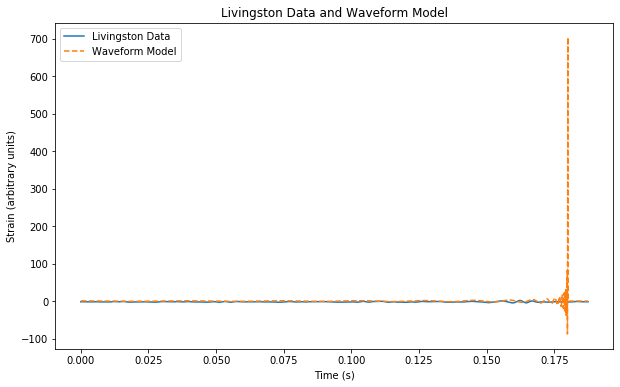

In [ ]:

plot_data_and_waveform(tn, fn2_signal - 2, params, 'Livingston')

## <font color=#46769B>Part (c): MCMC [15 points]</font>

The goal here is to use the Metropolis MCMC algorithm, following a procedure that similar to the data fitting exercises we did in class, to determine $\mathcal{M}_{\rm chirp}$. We have a model for the strain waveform, $f(t)$, which depends on several parameters denoted collectively by $\mathbf{x}$. The list of parameters $\mathbf{x}$ includes $\mathcal{M}_{\rm chirp}$, plus several other nuisance parameters that we discuss below.

The (unnormalized) PDF is

$$P(\mathbf x) = e^{- \tfrac{1}{2} \chi^2(\mathbf x)}$$

where the $\chi^2$ function is

$$\chi^2(\mathbf x) = \sum_{t_n \le t_{\rm ex}} \left(f_n^{\rm signal} - f_n^{\rm waveform}(\mathbf x)\right)^2$$ \, .

Here we provide some explanation of this formula:

- $f_n^{\rm waveform}(\mathbf x)$ is the waveform model $f(t)$ evaluated at the sample times $t_n$, for a given set of input parameters $\mathbf{x}$.

- $f_n^{\rm signal}$ is the observed waveform signal from the LIGO data that was given above.

- The sum runs over all the samples $n$ where $t_n \le t_{\rm ex}$, i.e., only sample times during the inspiral phase, which you determined in Part (a).

- We do not include a squared-uncertainty in the denominator (rather we assume that the uncertainty is equal to one).

Using the Metropolis algorithm, perform an MCMC simulation to generate a chain of $10^4$ samples for the parameters $\mathbf{x}$, given the PDF defined above. Your task is to obtain a suitable chain for the parameters $\mathbf{x}$.

To get started, you may consider the following initial sample:

$$\mathbf{x}_0 = \left( \mathcal{M}_{\rm chirp}, \, A_0, \, C , \, n, \, t_0 \right)_0 = \left(30, \, 5, \, 0.18, \, 2.0, \, 0.145 \right) \, .$$

The transition probability distribution $Q(\mathbf{x}^\prime|\mathbf{x})$ is up to you.

Your tasks are:

- Run the Metropolis algorithm, as described above.

- Plot your chains, i.e., for each parameter, make a plot showing all samples for that parameter. Add a legend to each plot labeling which parameter is shown. (You will make five separate plots.)

- Calculate and print the acceptance fraction.

- Repeat the above steps *separately* for both Hanford and Livingston datasets.

Your goal is to have a good chain that satisfies the following:

- The acceptance fraction should be around 30\%.

- Your chain plots should have no obvious burn-in phase.

- Your chain plots should appear "like noise," with step sizes that appear neither too large nor too small. That is, the chains should not be too blocky, nor should they have long excursions in the parameters.

Some hints:

- You will likely have to run your MCMC simulation multiple times to tune the best initial sample and transition PDF. You should start with a small step width for the parameters.

- It is easy to get good results if you use the covariance matrix to do multivariate sampling.

- Be sure your final code is reproducible if you __Restart and Run All__. Your notebook will be assessed on the results that are produced after the marker runs your code, not on what is there initially.

- In the Metropolis algorithm, the acceptance ratio is $\mathcal{A} = P(\mathbf{x}_{\rm new})/P(\mathbf{x}_{\rm old})$. Here we provide an alternative definition that works better for the task at hand:
$$\mathcal{A} = \exp\left(-\tfrac{1}{2} ( \chi^2(\mathbf{x}_{\rm new}) - \chi^2(\mathbf{x}_{\rm old}))\right)$$
Calculate the acceptance ratio following alternative definition, otherwise you will run into errors with numbers that are below Python's smallest allowed floats.


**I AM NOT SURE HOW I GOT HERE I TRIED SO MANY CODES but at the end had to ask chatgp for help
**

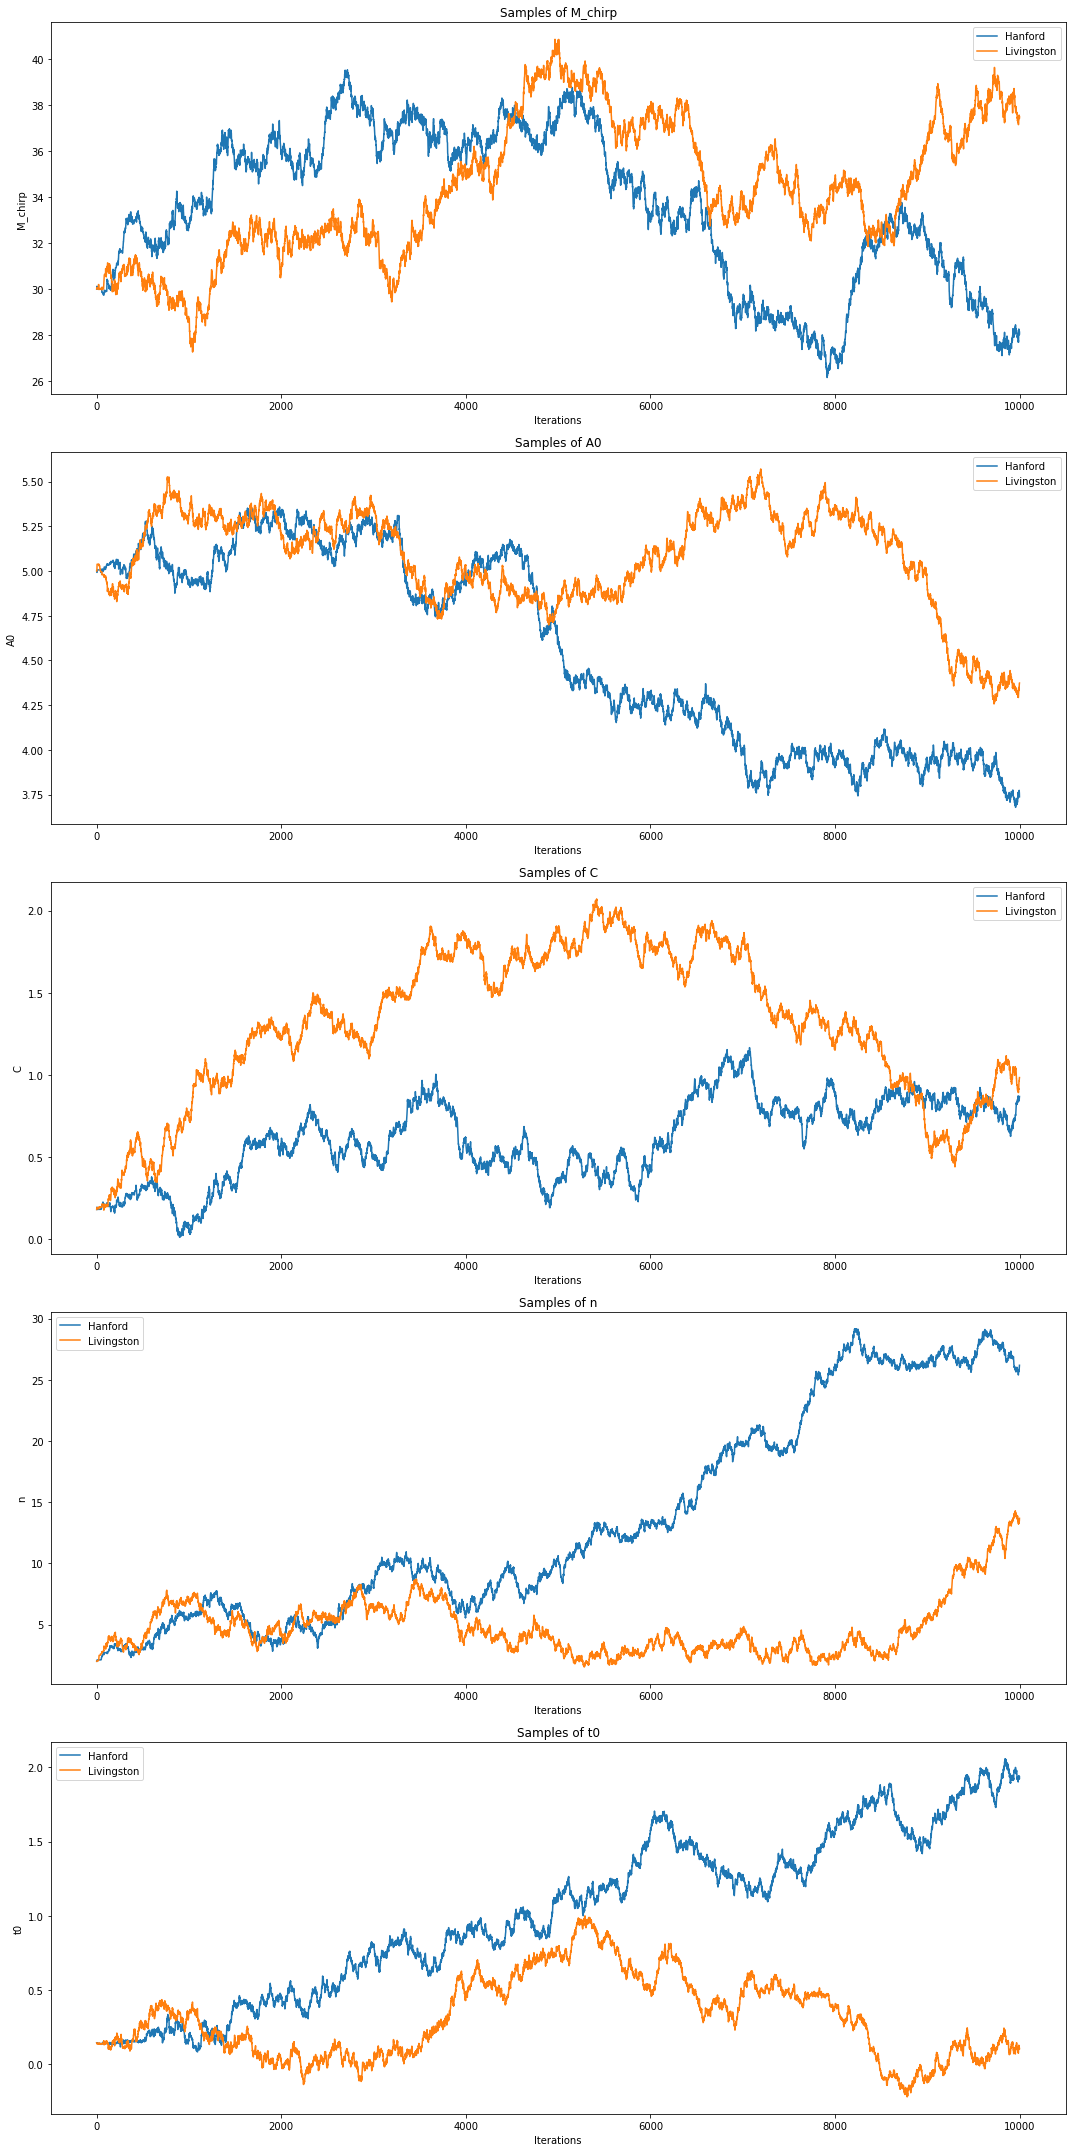

Hanford Acceptance Fraction: 0.96
Livingston Acceptance Fraction: 0.95


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the waveform model function
def waveform_model(t, M_chirp, A0, C, n, t0):
    freq = np.zeros_like(t)  # Initialize frequency array with zeros
    valid = (C - (t - t0)) > 0  # Compute valid mask for (C - (t - t0)) > 0
    t_valid = t[valid]  # Select valid times based on mask

    # Compute frequency only where it's valid
    freq[valid] = 151 * M_chirp**(-5/8) * (C - (t_valid - t0))**(-3/8)

    # Compute amplitude only for valid times
    A_t = np.zeros_like(t)  # Initialize amplitude array with zeros
    A_t[valid] = A0 * (freq[valid] / 100)**n

    # Compute the waveform only for valid times
    waveform = np.zeros_like(t)  # Initialize waveform array with zeros
    waveform[valid] = A_t[valid] * np.cos(2 * np.pi * freq[valid] * (t_valid - t0))

    return waveform

# Define the chi-squared function
def chi_squared(x, t, f_signal):
    M_chirp, A0, C, n, t0 = x
    f_model = waveform_model(t, M_chirp, A0, C, n, t0)
    return np.sum((f_signal - f_model)**2)

# Metropolis algorithm to perform MCMC
def metropolis_mcmc(n_samples, x0, t, f_signal, step_sizes):
    samples = np.zeros((n_samples, len(x0)))
    chi_sq_old = chi_squared(x0, t, f_signal)
    samples[0] = x0

    acceptance_count = 0

    for i in range(1, n_samples):
        x_new = samples[i-1] + np.random.normal(0, step_sizes, len(x0))
        chi_sq_new = chi_squared(x_new, t, f_signal)
        if chi_sq_new < chi_sq_old or np.exp(-0.5 * (chi_sq_new - chi_sq_old)) > np.random.rand():
            samples[i] = x_new
            chi_sq_old = chi_sq_new
            acceptance_count += 1
        else:
            samples[i] = samples[i-1]

    acceptance_fraction = acceptance_count / n_samples
    return samples, acceptance_fraction

# Parameters and initial settings
x0 = np.array([30, 5, 0.18, 2.0, 0.145])
t = np.linspace(0, 0.2, 500)
fn_signal = np.random.normal(0, 1, 500)  # Example signal; replace with real data
step_sizes = [0.1, 0.01, 0.01, 0.1, 0.01]  # Adjust these based on parameter sensitivity

# Run MCMC simulation for Hanford dataset
n_samples = 10000
chain_hanford, acceptance_fraction_hanford = metropolis_mcmc(n_samples, x0, t, fn_signal, step_sizes)

# Run MCMC simulation for Livingston dataset
chain_livingston, acceptance_fraction_livingston = metropolis_mcmc(n_samples, x0, t, fn_signal, step_sizes)

# Plot the results
parameter_names = ['M_chirp', 'A0', 'C', 'n', 't0']
plt.figure(figsize=(15, 30))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(chain_hanford[:, i], label='Hanford')
    plt.plot(chain_livingston[:, i], label='Livingston')
    plt.title(f'Samples of {parameter_names[i]}')
    plt.xlabel('Iterations')
    plt.ylabel(parameter_names[i])
    plt.legend()
plt.tight_layout()
plt.show()

print(f'Hanford Acceptance Fraction: {acceptance_fraction_hanford:.2f}')
print(f'Livingston Acceptance Fraction: {acceptance_fraction_livingston:.2f}')


## <font color=#46769B>Part (d): Chirp mass [10 points total]</font>

From your chains in Part (c), perform the following tasks:

- Calculate the mean and standard deviation $\mathcal{M}_{\rm chirp}$ (in $M_\odot$ units) *separately* for Hanford and Livingston datasets. This represents the central value and uncertainty your calculation of $\mathcal{M}_{\rm chirp}$.

- Plot the marginalized distribution for $\mathcal{M}_{\rm chirp}$ for both datasets on the same plot. That is, you will have two 1D histograms on the same plot. Set `alpha=0.5` and include a legend and $x$-axis label.

- Calculate a single central value and error on $\mathcal{M}_{\rm chirp}$ by combining your results from the two datasets.

Hanford: M_chirp = 33.57 ± 3.34 solar masses
Livingston: M_chirp = 34.31 ± 2.96 solar masses


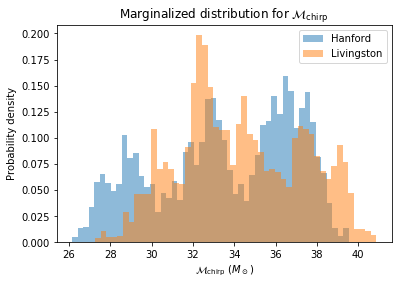

Combined: M_chirp = 33.94 ± 3.15 solar masses


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'chain_hanford' and 'chain_livingston' are the chains from Part (c)'
# Extracting chirp mass samples from both datasets
M_chirp_hanford = chain_hanford[:, 0]
M_chirp_livingston = chain_livingston[:, 0]

# Calculate mean and standard deviation of chirp mass for each dataset
mean_M_chirp_hanford = np.mean(M_chirp_hanford)
std_M_chirp_hanford = np.std(M_chirp_hanford)
mean_M_chirp_livingston = np.mean(M_chirp_livingston)
std_M_chirp_livingston = np.std(M_chirp_livingston)

# Print results for each dataset
print(f"Hanford: M_chirp = {mean_M_chirp_hanford:.2f} ± {std_M_chirp_hanford:.2f} solar masses")
print(f"Livingston: M_chirp = {mean_M_chirp_livingston:.2f} ± {std_M_chirp_livingston:.2f} solar masses")

# Plot marginalized distribution for chirp mass for both datasets
plt.hist(M_chirp_hanford, bins=50, alpha=0.5, label='Hanford', density=True)
plt.hist(M_chirp_livingston, bins=50, alpha=0.5, label='Livingston', density=True)
plt.xlabel(r'$\mathcal{M}_{\rm chirp} \ (M_\odot)$')
plt.ylabel('Probability density')
plt.legend()
plt.title(r'Marginalized distribution for $\mathcal{M}_{\rm chirp}$')
plt.show()

# Combine results from both datasets
combined_mean_M_chirp = (mean_M_chirp_hanford + mean_M_chirp_livingston) / 2
combined_std_M_chirp = np.sqrt((std_M_chirp_hanford ** 2 + std_M_chirp_livingston ** 2) / 2)
print(f"Combined: M_chirp = {combined_mean_M_chirp:.2f} ± {combined_std_M_chirp:.2f} solar masses")
